In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [2]:
Data=pd.read_csv('Fraud_Data.csv')
ip_country=pd.read_csv('IpAddress_to_Country.csv')

## find each user's country

In [3]:
country=[]
for ip in Data['ip_address']:
    country.append(ip_country[(ip>ip_country['lower_bound_ip_address']) & (ip <ip_country['upper_bound_ip_address'])]['country'].values)
    

                              

In [4]:
Data['country']=country

In [5]:
Data['country']=Data['country'].apply(lambda x: None if len(x)==0 else x[0])

## Exploratory Data Analysis

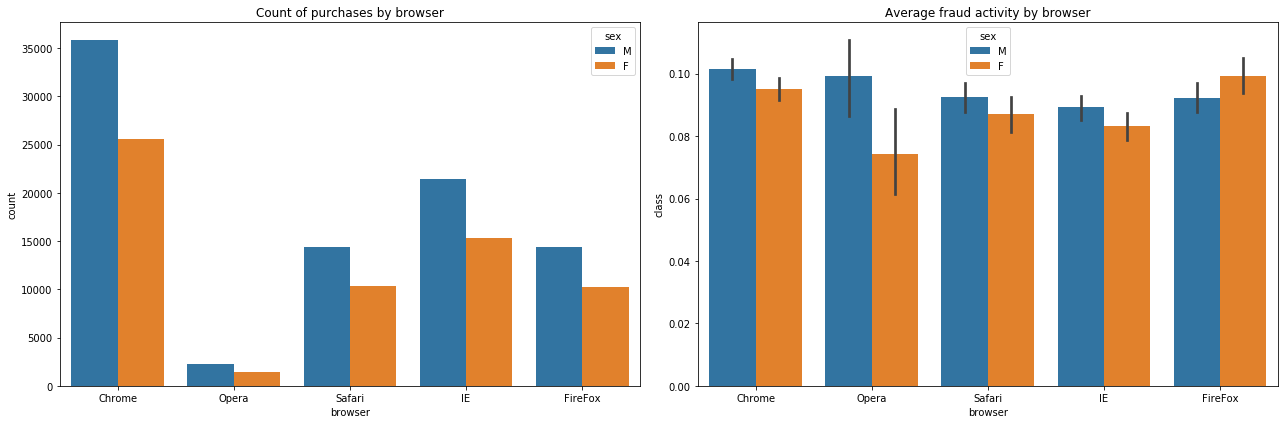

In [6]:
## checking fraud vs browser and sex
fig, ax=plt.subplots(1,2, figsize=(18,6))
sns.countplot(x='browser', hue='sex', data=Data, ax=ax[0])
ax[0].set_title('Count of purchases by browser', fontsize=12)
sns.barplot(x='browser', y='class', hue='sex', data=Data, ax=ax[1])
ax[1].set_title('Average fraud activity by browser', fontsize=12)
plt.tight_layout()
plt.show()

In [7]:
top5=Data.country.value_counts().index.values[:5]


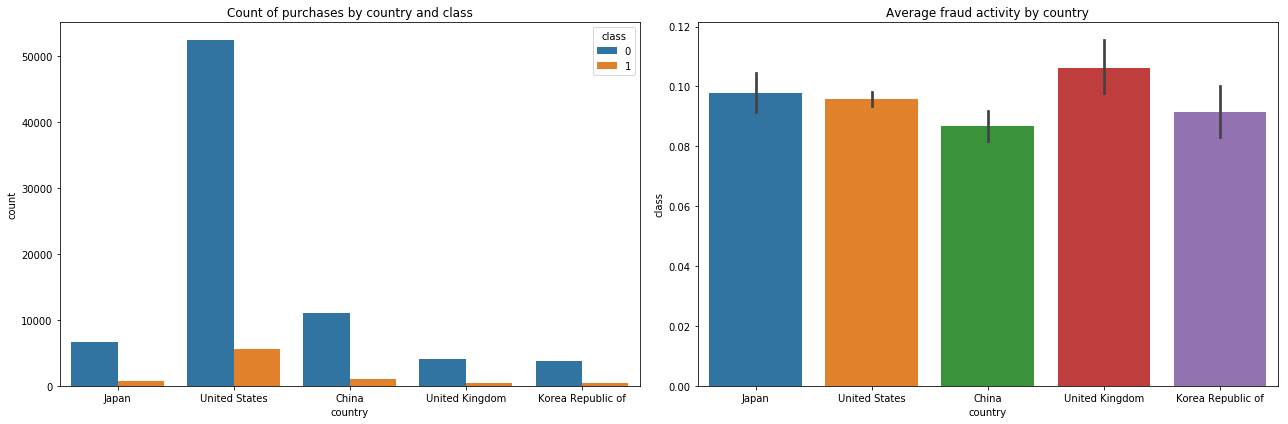

In [8]:
## checking fraud vs top 5 country by purchase
fig, ax=plt.subplots(1,2, figsize=(18,6))
sns.countplot(x='country', hue='class', data=Data[Data['country'].apply(lambda x: x in top5)], ax=ax[0])
ax[0].set_title('Count of purchases by country and class', fontsize=12)
sns.barplot(x='country', y='class', data=Data[Data['country'].apply(lambda x: x in top5)], ax=ax[1])
ax[1].set_title('Average fraud activity by country', fontsize=12)
plt.tight_layout()
plt.show()

## build a model to predict fraud

## Feature engineering

In [9]:
Data['interval']=(pd.to_datetime(Data['purchase_time'])-pd.to_datetime(Data['signup_time'])).apply(lambda x: x.total_seconds())

In [10]:
ip_con=Data.groupby(['ip_address'])['purchase_time'].count().reset_index()
ip_con.columns=['ip_address','ip_count']
Data=Data.merge(ip_con, how='left', on='ip_address')


In [11]:
device_con=Data.groupby(['device_id'])['purchase_time'].count().reset_index()
device_con.columns=['device_id','dev_count']
Data=Data.merge(device_con, how='left', on='device_id')

In [12]:
Data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,interval,ip_count,dev_count
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0,12,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,None,492085.0,1,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,1,1


In [13]:
columns_of_interest=['purchase_value','source','browser','sex','age','country','interval','ip_count','dev_count']

In [14]:
DF=Data[columns_of_interest]

In [15]:
DF=pd.get_dummies(DF)

In [16]:
DF.head()

,purchase_value,age,interval,ip_count,dev_count,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,...,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe
0,34,39,4506682.0,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,16,53,17944.0,1,1,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,15,53,1.0,12,12,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
3,44,41,492085.0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,39,45,4361461.0,1,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

clf1=LogisticRegression()
clf2=GaussianNB()
clf3=RandomForestClassifier()
clf4=RandomForestClassifier(class_weight='balanced')
clf5=SVC(kernel='linear', probability=True)



In [18]:
##separate data into training and testing sets (0.8 and 0.2)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(DF, Data['class'], test_size=0.2)

In [19]:
from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(4, random_state=42)   


In [20]:
from sklearn.metrics import roc_auc_score

In [21]:
## write a loop to get validation score and test score for all 3 classifiers:

def get_scores(classifier, Train, Train_tgt, Test, Test_tgt):
    val_pred=np.zeros(len(Train))
    test_pred=np.zeros(len(Test))
    for trn_idx, val_idx in skf.split(Train, Train_tgt):
        classifier.fit(Train.iloc[trn_idx], Train_tgt.iloc[trn_idx])
        val_pred[val_idx]=classifier.predict_proba(Train.iloc[val_idx])[:,1]
        test_pred+=classifier.predict_proba(Test)[:,1]/4.0
    val_score=roc_auc_score(Train_tgt, val_pred)
    test_score=roc_auc_score(Test_tgt, test_pred)
    return {'classifier':classifier,'val_score':val_score,'test_score':test_score}

In [22]:
get_scores(clf1, X_train, y_train, X_test, y_test)

{'classifier': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'val_score': 0.7662424280482336,
 'test_score': 0.767632198807626}

In [23]:
get_scores(clf2, X_train, y_train, X_test, y_test)

{'classifier': GaussianNB(priors=None),
 'val_score': 0.7662288009045184,
 'test_score': 0.7676761661203488}

In [24]:
get_scores(clf3, X_train, y_train, X_test, y_test)

{'classifier': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'val_score': 0.8228626640985301,
 'test_score': 0.8411971454917249}

In [25]:
get_scores(clf4, X_train, y_train, X_test, y_test)

{'classifier': RandomForestClassifier(bootstrap=True, class_weight='balanced',
             criterion='gini', max_depth=None, max_features='auto',
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
             verbose=0, warm_start=False),
 'val_score': 0.8223412806587038,
 'test_score': 0.8403486574434331}

In [ ]:
get_scores(clf5, X_train, y_train, X_test, y_test)